In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/github/DeepLDSIR')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
sys.path.insert(0, './models')

In [3]:
import tensorflow as tf
import numpy as np
import scipy.io as sio

from utils import *
from models.Alpha8L import *
from matplotlib import pyplot as plt
from admm import ADMM as algADMM

In [4]:
data_path = "/content/drive/My Drive/hdsp/data/kaist_dataset/train/Image_1.mat"


RGB = [22, 12, 4]
h = sio.loadmat(data_path)['img']
h = np.expand_dims(h,0)         
Batch_size, Img_heigth , Img_width , Channels = h.shape                
coded_aperture = np.load('ca.npy')

y = dd_cassi(h,coded_aperture)

In [5]:
print(coded_aperture.shape)

(1, 512, 542, 1, 1)


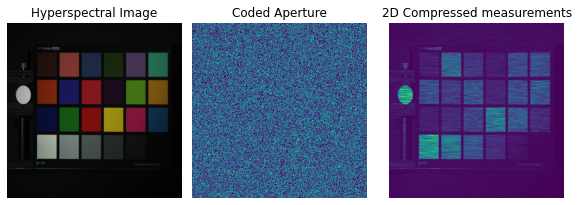

In [6]:
fig, axs = plt.subplots(1,3,constrained_layout=True , figsize=(8,3))
_ = [ x.axis('Off') for x in axs]

axs[0].imshow(h[0,:,:,:][:,:,RGB]) , axs[0].set_title('Hyperspectral Image')
axs[1].imshow(coded_aperture[0,:,:,0,0], aspect=1.06) , axs[1].set_title('Coded Aperture')
axs[2].imshow(y[0,:,:,0]), axs[2].set_title('2D Compressed measurements')
plt.show()

In [7]:
input_size = (Img_heigth, Img_width, Channels)
weights = './weights/Alpha8L_Kaist.h5'

In [8]:
optimizad = tf.keras.optimizers.Adam(learning_rate=1e-4)

main_model = HSI_net(coded_aperture, input_size=input_size,  pretrained_weights=weights)

autoencoder = main_model.autoencoder
encode = main_model.encoder
decode = main_model.decoder

autoencoder.compile(optimizer=optimizad, loss='mean_squared_error')
encode.compile(optimizer=optimizad, loss='mean_squared_error')
decode.compile(optimizer=optimizad, loss='mean_squared_error')

In [9]:
algorit_admm = algADMM(main_model)
epochs , steps = 200 , 20
params = [1 , 0.1 , 0.3]

In [10]:
h_est = algorit_admm(y,epochs,steps,params)

||temp-t_old||102.1340058524182||temp2-t2_old||219.26727856597762
||temp-t_old||36.595013||temp2-t2_old||42.53251
||temp-t_old||18.859728||temp2-t2_old||29.136492
||temp-t_old||11.182459||temp2-t2_old||22.078474
||temp-t_old||7.7834797||temp2-t2_old||15.830159
||temp-t_old||5.651592||temp2-t2_old||10.446803
||temp-t_old||4.5896716||temp2-t2_old||6.684113
||temp-t_old||4.262213||temp2-t2_old||4.2329803
||temp-t_old||4.1942315||temp2-t2_old||2.8119633
||temp-t_old||4.234061||temp2-t2_old||2.0135746
||temp-t_old||4.2834425||temp2-t2_old||1.6040776
||temp-t_old||4.3584247||temp2-t2_old||1.443359
||temp-t_old||4.4317446||temp2-t2_old||1.4329748
||temp-t_old||4.4875164||temp2-t2_old||1.4377981
||temp-t_old||4.542848||temp2-t2_old||1.4360818
||temp-t_old||4.589541||temp2-t2_old||1.4521459
||temp-t_old||4.662324||temp2-t2_old||1.4686469
||temp-t_old||4.7232375||temp2-t2_old||1.473182
||temp-t_old||4.789053||temp2-t2_old||1.4901805
||temp-t_old||4.839949||temp2-t2_old||1.5119482
recons done


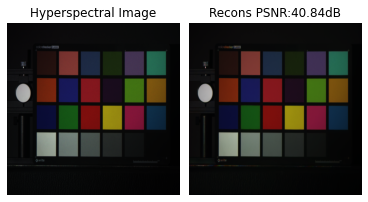

In [11]:
psnr = round( tf.image.psnr(h,h_est,1).numpy()[0],2)

fig, axs = plt.subplots(1,2,constrained_layout=True , figsize=(5,3))
_ = [ x.axis('Off') for x in axs]

axs[0].imshow(h[0,:,:,:][:,:,RGB]) , axs[0].set_title('Hyperspectral Image')
axs[1].imshow(h_est[0,:,:,:][:,:,RGB]) , axs[1].set_title('Recons PSNR:' + str(psnr) + 'dB')

plt.show()